In [256]:
import keras
from keras.layers import Input, Activation, Dense, Conv2D, MaxPooling2D,Flatten,Lambda
from keras.models import Model
import keras.backend as K
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
digit_input = Input(shape=(105,105,1))

x = Conv2D(64, (10, 10),activation='relu',input_shape=(105,105,1))(digit_input)
x = MaxPooling2D()(x)
x = Conv2D(128, (8, 8),activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, (6, 6),activation ='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(256, (4, 4),activation='relu')(x)
out = Flatten()(x)
#out = Dense(4096,activation='sigmoid')(x)
vision_model = Model(digit_input,out)

letter1 = Input(shape=(105,105,1))
letter2 = Input(shape=(105,105,1))

out_1 = vision_model(letter1)
out_2 = vision_model(letter2)

def m_dist(A,B):
    return K.sum(K.abs(A-B),axis=1,keepdims=True)

merged_vector = Lambda(lambda x:m_dist(x[0],x[1]), output_shape=lambda inp_shp:(inp_shp[0][0],1))([out_1,out_2])

out_fin = Dense(4096,activation="sigmoid")(merged_vector)
final_output = Dense(1,activation="sigmoid")(out_fin)

final_model = keras.models.Model(inputs=[letter1, letter2], outputs=final_output)

In [477]:
import math
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses=[]
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

def step_decay(epoch):
    if epoch%3:
        return K.get_value(optimizer.lr)*0.99
    return K.get_value(optimizer.lr)
  
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
filepath="checkpoints/weight1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopper = EarlyStopping(monitor='loss', min_delta=1e-5, patience=25, verbose=1)

callbacks_list = [lrate,loss_history,checkpoint,early_stopper]

optimizer = Adam(lr=3e-4,amsgrad=True)

In [494]:
final_model.compile(optimizer=optimizer,
                   loss='binary_crossentropy',
                   metrics=['binary_accuracy'],)

In [495]:
final_model.layers[2].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 105, 105, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 41, 41, 128)       524416    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)       589952    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 128)         0         
__________

In [496]:
from matplotlib import pyplot as plt 
%matplotlib inline
import glob
import cv2
import numpy as np
from collections import Counter
from IPython.core.display import display, HTML
import random

In [497]:
dataset_train_path , dataset_evaluation_path = ("python/images_background/","python/images_evaluation/")

languages = [path.split("/")[-1] for path in glob.glob(dataset_train_path+"*")]
languages_evaluation = [path.split("/")[-1] for path in glob.glob(dataset_evaluation_path+"*")]

In [ ]:
all_alphabets = {language:[cv2.cvtColor(cv2.imread(image),cv2.COLOR_RGB2GRAY) for image in glob.glob(dataset_train_path+language+"/*/*")]\
                                                                  for language in languages }
all_images =  np.vstack([np.array(all_alphabets[key]) for key in all_alphabets])

all_evaluation_alphabets = {language:[cv2.cvtColor(cv2.imread(image),cv2.COLOR_RGB2GRAY) for image in glob.glob(dataset_evaluation_path+language+"/*/*")]\
                                                                  for language in languages_evaluation[5:] }
all_evaluation_images =  np.vstack([np.array(all_evaluation_alphabets[key]) for key in all_evaluation_alphabets])

In [491]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(15,15),cmap=None):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)

    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[ind],cmap=cmap)
        axeslist.ravel()[ind].set_title(ind)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

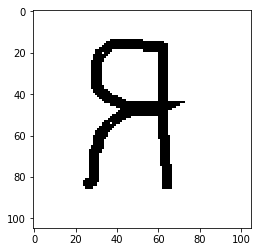

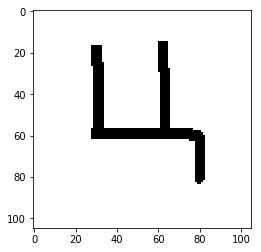

In [232]:
%matplotlib inline
for image in (batch[0][0][4],batch[0][1][4]) :
    plt.imshow(image.reshape(105,105),cmap="bone")
    plt.show()

In [498]:
train_data_gen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization = True,
    rotation_range =10,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05,
    zoom_range = 0.05,
    #rescale = 1./255         
)

def flip(p):
    return random.random() < p

def augmented_generator(features,batch_size,distribution,validation):
    
    batch_features = np.zeros((batch_size, 2,105, 105,1))
    batch_labels = np.zeros((batch_size,1))
    macro_dict = all_evaluation_alphabets if validation else all_alphabets
    lengthes = np.insert(np.cumsum([len(macro_dict[key]) for key in macro_dict]),0,0)
    
    while True:

        for i in range(batch_size):
            if flip(distribution):
                not_insame_class = True
                while not_insame_class:
                    indecies= np.random.choice(len(features),2)
                    not_insame_class = np.argmax(lengthes-indecies[0]>0) != np.argmax(lengthes-indecies[1]>0)
                batch_labels[i] = not_insame_class
            else:
                
                first = np.searchsorted(lengthes,np.random.randint(1,len(features)))
                indecies = np.zeros(2)
                while abs(indecies[0]-indecies[1]) < 20 : indecies = np.random.choice(range(lengthes[first-1],lengthes[first]),2)
                batch_labels[i] = True
    
            image1,image2 = features[indecies[0]].reshape(105,105,1),features[indecies[1]].reshape(105,105,1)
            if not validation and flip(0.5): 
                generator1 , generator2 = train_data_gen.flow(image1[np.newaxis,:],batch_size=1) , train_data_gen.flow(image2[np.newaxis,:],batch_size=1)
                image1,image2 = next(generator1),next(generator2)
            batch_features[i] = (image1,image2)
            
        yield [batch_features[:,0],batch_features[:,1]], batch_labels

In [499]:
history2 = final_model.fit_generator(augmented_generator(all_images,128,0.5,False),
        validation_data= augmented_generator(all_evaluation_images,128,0.5,True),
        validation_steps = 50,
        steps_per_epoch=50,
        verbose=2,
        epochs=1000,          
        callbacks=callbacks_list)

Epoch 1/2
 - 35s - loss: 0.9387 - binary_accuracy: 0.5187
lr: 9.900000000000001e-05
Epoch 2/2
 - 37s - loss: 0.7141 - binary_accuracy: 0.5156
lr: 9.801e-05


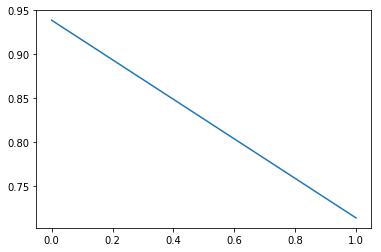

In [509]:
plt.plot(history.history['loss'])

In [554]:
def plot_kernels(model,layer_num):
    
    plt.imshow(model.get_weights()[layer_num][:, :, :, 0].squeeze(), cmap='gray')

In [553]:
layer=final_model.get_layer(index=0)

In [523]:
plot_kernels()

{'binary_accuracy': [0.51875, 0.515625],
 'loss': [0.9386626899242401, 0.7140816032886506]}